In [1]:
#@title
######################################################
# Import libraries
######################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split

import pickle
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [2]:
#@title
######################################################
# Helper Methods
######################################################

def load_dataset(filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data = pd.read_csv(filename+extension)
    elif 'xls' in extension:
        data = pd.read_excel(filename+extension)
    elif 'pkl' in extension:
        data = pd.DataFrame(pickle.load(open(filename+extension, 'rb')))
    return data

def save_dataset(data, filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data.to_csv(filename+extension)
    elif 'xls' in extension:
        data.to_excel(filename+extension, index=False)
    elif 'pkl' in extension:
        pickle.dump(data, open(filename+extension, 'wb'))

def check_df(dataframe, head=5):
    """
    Prints out the shape, types, head, missing values and quantiles of the dataframe
    Parameters
    ----------
    dataframe
    head

    Returns
    -------
    No return
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("################ Missing Values ################")
    print(dataframe.isnull().sum())

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Determines the categorical, numerical and categorical but cardinal columns.

    Parameters
    ------
        dataframe: dataframe
                dataframe whihc inludes the columns
        cat_th: int, optional
                class threshold valuse for determining numeric but categorical variable
        car_th: int, optional
                class threshold valuse for determining categoric but cardinal variable

    Returns
    ------
        cat_cols: list
                categorical columns
        num_cols: list
                numerical columns
        cat_but_car: list
                categoric but cardinal columns

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total columns
        cat_cols = all_cat_cols + num_but_cat - cat_but_car
        num_cols = all_num_cols - num_but_cat
    """

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")

    # cat cols
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    print(f'init cat_cols: {len(cat_cols)}')

    # num cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    print(f'init num_cols: {len(num_cols)}')

    # num but cat cols
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat but car cols
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    print(f'cat_but_car: {len(cat_but_car)}')

    # cat cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    print(f'final cat_cols: {len(cat_cols)}')

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f'final num_cols: {len(num_cols)}')

    return cat_cols, num_cols, cat_but_car

def new_feature_interval(dataframe, col, interval_value, header="new"):
    if header == "new":
        new_col = "new_" + col
    else:
        new_col = header
    for intrvl, val in interval_value.items():
        dataframe.loc[[var in intrvl for var in dataframe[col]], new_col] = val

def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show()
    
def plot_bar(df, x, y, title, save=None):
    sns.set(font_scale=1)
    sns.barplot(x=x, y=y, data=df)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    if save != None:
        plt.savefig(save)

def plot_count(df, x, title, save=None):
    sns.set(font_scale=1)
    sns.barplot(x=x, y=y, data=df)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    if save != None:
        plt.savefig(save)

def cat_cols_summary(dataframe, cat_cols, plot=False):
    """
    Ratio of the categorical classes in a column
    Parameters
    ----------
    dataframe
    col_name
    plot

    Returns
    -------
    No return
    """
    print("############## Frequency and Ratio #############")
    print(pd.DataFrame({"Freq": dataframe[cat_cols].value_counts(),
                        "Ratio": 100 * dataframe[cat_cols].value_counts() / len(dataframe)}).rename_axis(cat_cols))

    if plot:
        for col in cat_cols:
            sns.countplot(x=dataframe[col], data=dataframe)
            plt.show()

def num_cols_summary(dataframe, num_cols, plot=False):
    """
    Numerical variable exploration
    Parameters
    ----------
    dataframe
    numerical_col
    plot

    Returns
    -------
    No return
    """
    print("################### Describe ###################")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40,
                 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_cols].describe(quantiles).T)

    if plot:
        for col in num_cols:
            dataframe[col].hist(bins=20)
            plt.xlabel(col)
            plt.title(col)
            plt.show()

def target_vs_num_cols_summary(dataframe, target, num_col):
    """
    Prints out the defined numeric variable mean of the target classes
    Parameters
    ----------
    dataframe
    target
    num_col

    Returns
    -------
    No return
    """
    print(pd.DataFrame(
        {num_col+"_MEAN": dataframe.groupby(target).agg({num_col: "mean"})[num_col]}), end="\n\n\n")

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Appoints the lower and upper thresholds by use of quantile
    Parameters
    ----------
    dataframe
    col_name
    q1: first quantile percentage
    q3: third quantile percentage

    Returns
    -------
    low_limit and up_limit thresholds as tupple
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Checks if there is an outlier and return bool value
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    outlier existance as bool
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, cat_cols, drop_first=False, dummy_na=False):
    """
    Encodes the column of the dataframe with binary labels
    Parameters
    ----------
    dataframe
    categorical_cols
    drop_first

    Returns
    -------
    The one-hot encoded columns added dataframe
    """
    dataframe = pd.get_dummies(
        dataframe, columns=cat_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe

def robust_scaling(dataframe, col_name):
    """
    Scale features using statistics that are robust to outliers.
    This Scaler removes the median and scales the data according to the quantile range (defaults to IQR)
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    Robust scaled dataframe
    """
    rs = RobustScaler()
    dataframe[col_name] = rs.fit_transform(dataframe[[col_name]])
    return dataframe


In [3]:
######################################################
# Load Data Set
######################################################

url = "https://raw.githubusercontent.com/atacanozkan/health_insurance_cost_prediction/main/insurance"
df = load_dataset(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


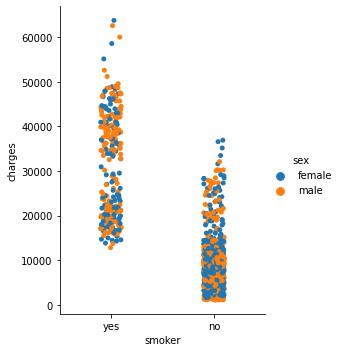

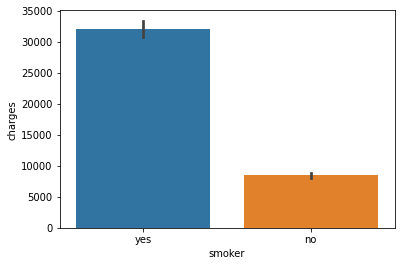

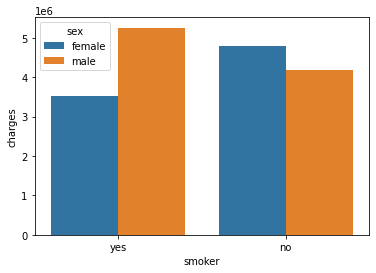

In [52]:
# sns.catplot(x="sex", y="charges", col = 'region', hue = 'smoker', data=df, height=5, aspect=.8)
sns.catplot(x="smoker", y="charges", hue = 'sex', data=df, height=5, aspect=.8)
plt.show()
sns.barplot(x="smoker", y="charges", data=df)
plt.show()
sns.barplot(x="smoker", y="charges", hue = 'sex', data=df, ci=None, estimator=sum)
plt.show()

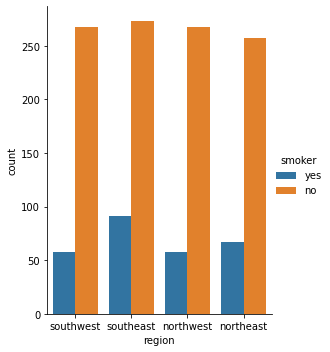

In [39]:
sns.catplot(x="region", kind="count", hue = 'smoker', data=df, height=5, aspect=.8)
plt.show()

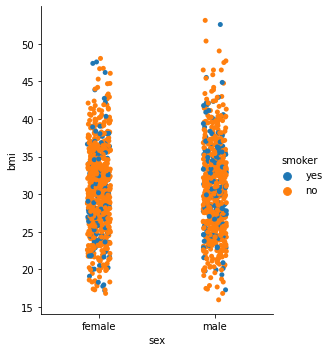

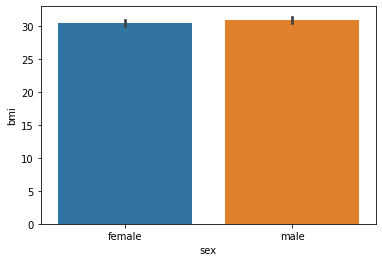

In [54]:
sns.catplot(x="sex", y="bmi", hue = 'smoker', data=df, height=5, aspect=.8)
plt.show()
sns.barplot(x="sex", y="bmi", data=df)
plt.show()

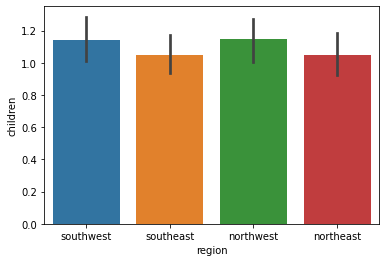

In [41]:
sns.barplot(x="region", y="children", data=df)
plt.show()

#sns.histplot(binwidth=0.5, x="Playing_Role", hue="Bought_By", data=df, stat="count", multiple="stack")

In [48]:
df.groupby('region').agg(['count'])['children']

,count
region,
northeast,324
northwest,325
southeast,364
southwest,325


In [4]:
######################################################
# Exploratory Data Analysis
######################################################

# Tablonun özet istatistikleri:

check_df(df, 5)
df.describe()

# Kategorik ve sayısal değişkenlerin belirlenmesi
print("")
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.append(cat_cols.pop(cat_cols.index('children')))
check_df(df, 5)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [7]:
    var = df['sex']
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    varValue

male      676
female    662
Name: sex, dtype: int64

In [8]:
 varValue.index

Index(['male', 'female'], dtype='object')

In [9]:
 varValue.index.values

array(['male', 'female'], dtype=object)

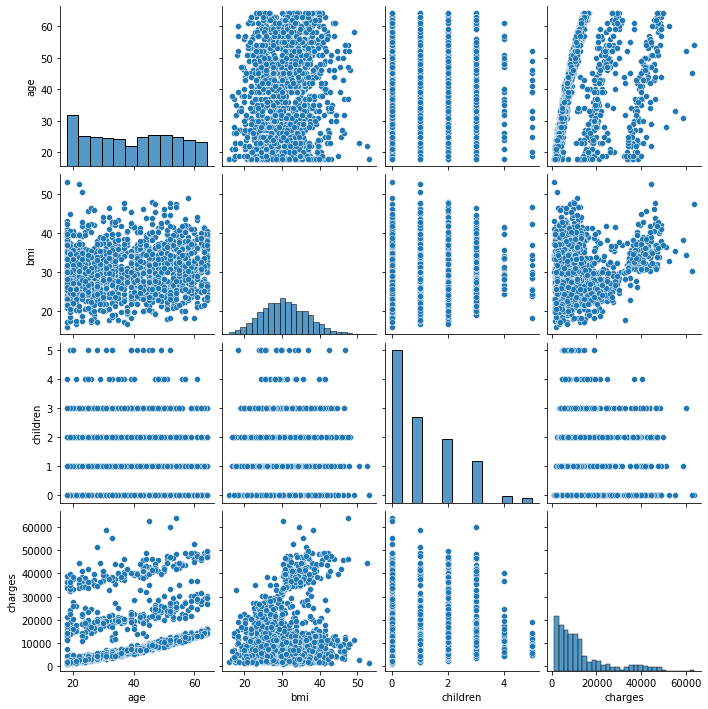

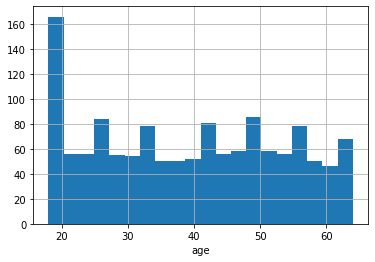

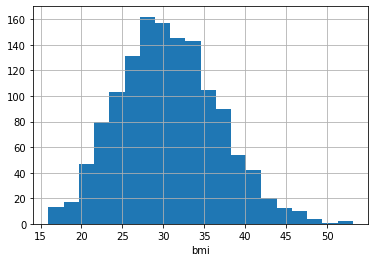

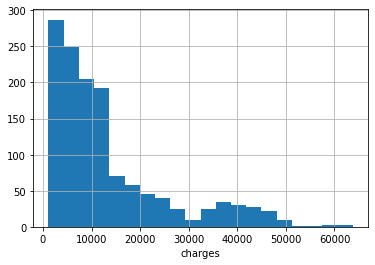

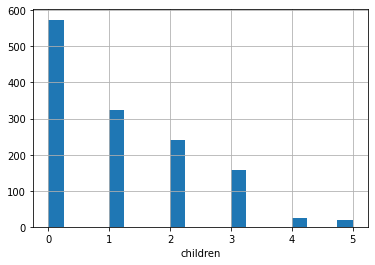

In [5]:
##########################
# Görsel Analiz
##########################
sns.pairplot(df)
plt.show()

for col in num_cols:
    plot_numerical_col(df, col)

In [ ]:
######################################################
# Feature Engineering
######################################################
new_feature_interval(df, 'age',
                   {
                    pd.Interval(-np.inf, 18, closed='neither'):'young',
                    pd.Interval(18, 44, closed='left'):'mature',
                    pd.Interval(44, 64, closed='left'):'senior',
                    pd.Interval(64, np.inf, closed='left'):'old'
                   }
                   )

df['bmi_age'] = df['bmi']/df['age']

# Tablonun özet istatistikleri:
check_df(df)   

##################### Shape #####################
(1338, 8)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
new_age      object
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges new_age
0   19  female 27.900         0    yes  southwest 16884.924  mature
1   18    male 33.770         1     no  southeast  1725.552  mature
2   28    male 33.000         3     no  southeast  4449.462  mature
3   33    male 22.705         0     no  northwest 21984.471  mature
4   32    male 28.880         0     no  northwest  3866.855  mature
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges new_age
1333   50    male 30.970         3     no  northwest 10600.548  senior
1334   18  female 31.920         0     no  northeast  2205.981  matu

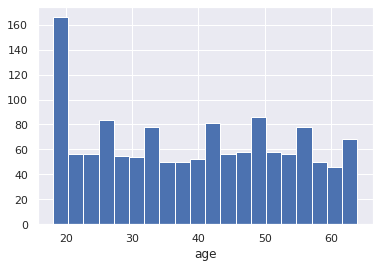

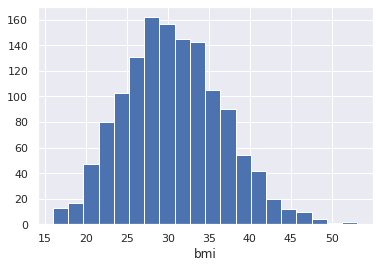

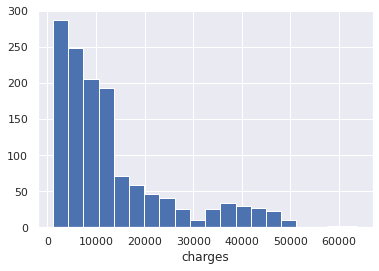

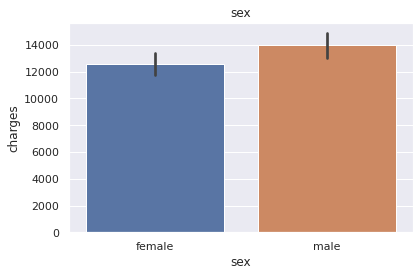

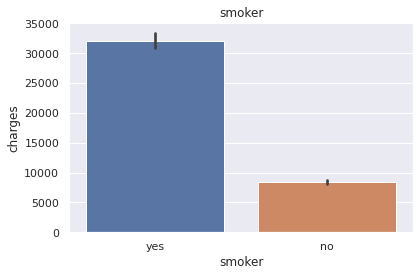

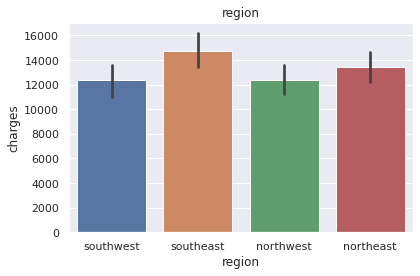

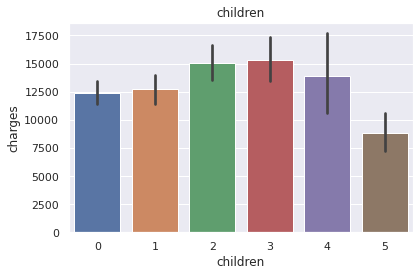

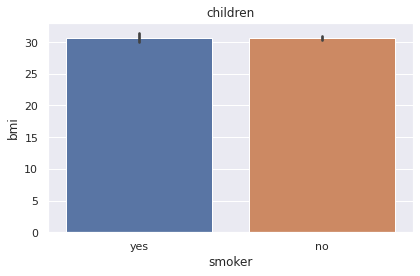

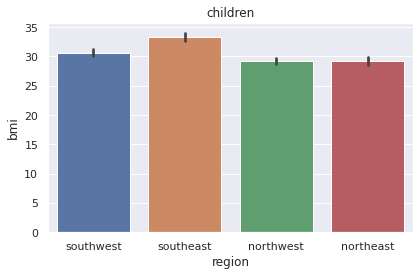

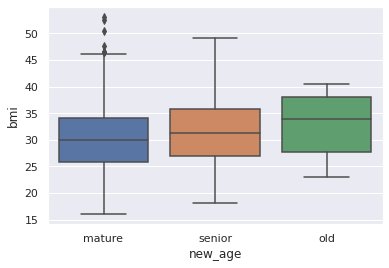

In [ ]:
##########################
# Görsel Analiz
##########################
for col in cat_cols:
    plot_bar(df, col, 'charges', col)

plot_bar(df, 'smoker', 'bmi', col)
plot_bar(df, 'region', 'bmi', col)
sns.boxplot(x='new_age',y='bmi',data=df)

In [ ]:
##########################
# Target Analizi
##########################

# Tüm kategorik değişkenlerin özet istatistikleri:
cat_cols_summary(df, 'charges')

##########################
# Feature Analizi
##########################

# Tüm sayısal değişkenlerin özet istatistikleri:
num_cols_summary(df, num_cols, False)

##########################
# Target vs Features Analizi
##########################
for col in num_cols:
    target_vs_num_cols_summary(df, "charges", col)

######################################################
# Data Preprocessing (Veri Ön İşleme)
######################################################

# Eksik değer incelemesi:
df.isnull().sum()

# Aykırı değer incelemesi:
for col in num_cols:
    print(col, check_outlier(df, col))


#############################################
# One-Hot Encoding
#############################################
df = one_hot_encoder(df, cat_cols)

# Tablonun özet istatistikleri:
check_df(df)



#############################################
# Feature Scaling (Özellik Ölçeklendirme)
#############################################
for col in num_cols:
    df[col] = robust_scaling(df, col)

df.head()

# save_dataset(df, 'insurance_data_prep', '.pkl')

In [ ]:
#######################################
# Hitters
#######################################

# !pip install xgboost
# !pip install lightgbm
# conda install -c conda-forge lightgbm
# !pip install catboost

import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

from helpers.data_preparation import *
from helpers.exploratory_data_analysis import *


df = pd.read_csv("datasets/hitters.csv")
df.head()

#######################################
# Quick Data Preprocessing
#######################################

df.dropna(inplace=True)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

for col in cat_cols:
    cat_summary(df, col)

for col in cat_cols:
    df.loc[:, col] = label_encoder(df, col)

check_df(df)

y = df["Salary"]
X = df.drop(["Salary"], axis=1)

######################################################
# Base Models
######################################################

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          # ("CatBoost", CatBoostRegressor(verbose=False))
          ]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


######################################################
# Automated Hyperparameter Optimization
######################################################


cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01, 0.01],
                  "max_depth": [5, 8, 12, 20],
                  "n_estimators": [100, 200, 300, 500],
                  "colsample_bytree": [0.5, 0.8, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

regressors = [("CART", DecisionTreeRegressor(), cart_params),
              ("RF", RandomForestRegressor(), rf_params),
              ('XGBoost', XGBRegressor(objective='reg:squarederror'), xgboost_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


######################################################
# # Stacking & Ensemble Learning
######################################################

voting_reg = VotingRegressor(estimators=[('RF', best_models["RF"]),
                                         ('LightGBM', best_models["LightGBM"])])

voting_reg.fit(X, y)


np.mean(np.sqrt(-cross_val_score(voting_reg, X, y, cv=10, scoring="neg_mean_squared_error")))

######################################################
# Prediction for a New Observation
######################################################

X.columns
random_user = X.sample(1, random_state=45)
voting_reg.predict(random_user)
